# Imports

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# For neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# EDA

In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Data inspection
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [4]:
print("\nDataset Summary:")
print(df.describe())


Dataset Summary:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [5]:
print("\nChecking Null Values")
print(df.isna().sum())


Checking Null Values
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [6]:
# Summary statistics of categorical columns
print("\nSummary of categorical columns:")
print(df.describe(include='object'))


Summary of categorical columns:
                           Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      204      889
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7        4      644


# Visualization

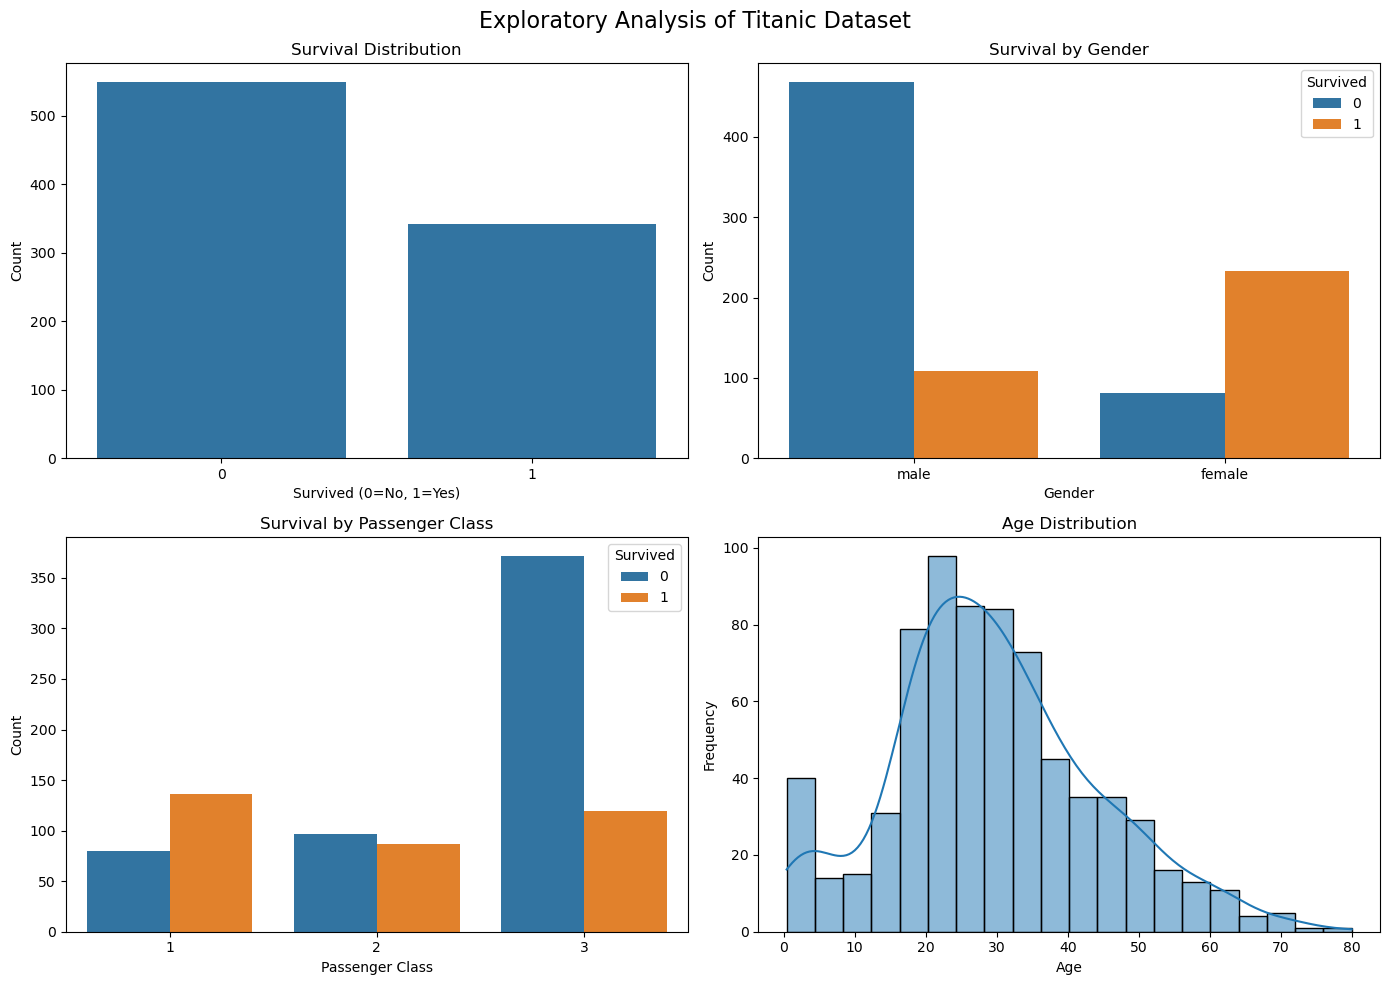

In [7]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Exploratory Analysis of Titanic Dataset', fontsize=16)

# Plot 1: Survival count
sns.countplot(x='Survived', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Survival Distribution')
axes[0, 0].set_xlabel('Survived (0=No, 1=Yes)')
axes[0, 0].set_ylabel('Count')

# Plot 2: Survival by sex
sns.countplot(x='Sex', hue='Survived', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Survival by Gender')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Count')

# Plot 3: Survival by Pclass
sns.countplot(x='Pclass', hue='Survived', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Survival by Passenger Class')
axes[1, 0].set_xlabel('Passenger Class')
axes[1, 0].set_ylabel('Count')

# Plot 4: Age distribution
sns.histplot(data=df, x='Age', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Age Distribution')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

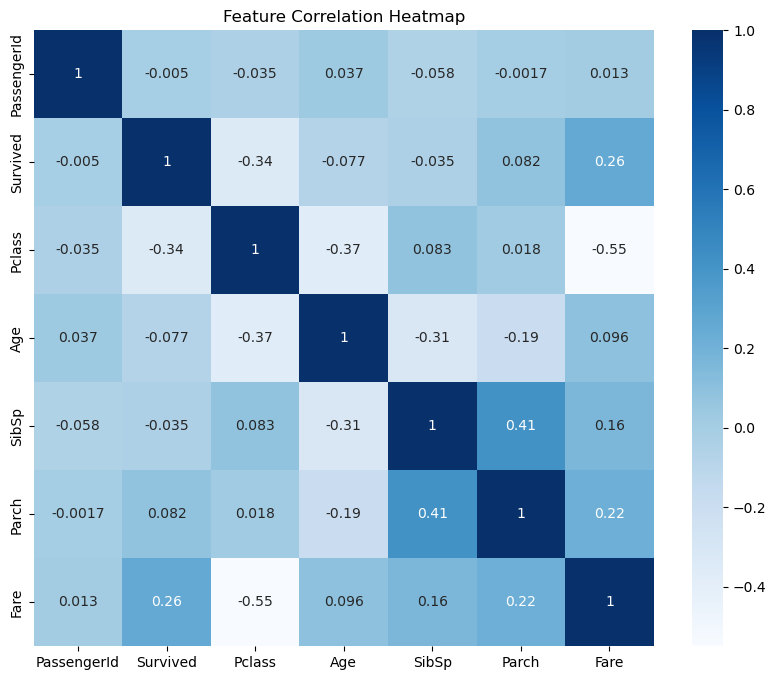

In [8]:
# Correlation heatmap for numerical features
df_num = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 8))
sns.heatmap(df_num.corr(), annot=True, cmap='Blues')
plt.title("Feature Correlation Heatmap")
plt.show()

# Data Pre-processing

In [9]:
# Handling Outliers for numerical columns
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1                   # Interquartile range
    lower_bound = Q1 - 1.5 * IQR    # Lower bound
    upper_bound = Q3 + 1.5 * IQR    # Upper bound
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [10]:
# Apply outlier removal to Fare and Age
df = remove_outliers(df, 'Fare')
df = remove_outliers(df, 'Age')

In [11]:
# Define preprocessing for numerical and categorical features
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Sex', 'Embarked', 'Pclass']

In [12]:
# Handle Missing Values 

# For age column
age_mean = df['Age'].mean()
df['Age'].fillna(age_mean, inplace=True)
print(f"- Filled missing Age values with mean: {age_mean:.2f}")

# For Cabin column
df.drop(columns=['Cabin'], inplace=True)

- Filled missing Age values with mean: 28.15


C:\Users\421094\AppData\Local\Temp\ipykernel_2520\2831166547.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(age_mean, inplace=True)


In [13]:
# Check if any missing values remain
print("\nRemaining missing values after handling:")
print(df.isna().sum())


Remaining missing values after handling:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [14]:
# Encoding Categorical Data
label_enc = LabelEncoder()
df['Sex'] = label_enc.fit_transform(df['Sex'])
df['Embarked'] = label_enc.fit_transform(df['Embarked'])

In [15]:
# Selecting Features and Target Variable
features = ['Sex','Embarked','Pclass','Fare','Parch','Age','SibSp']
target = 'Survived'
X = df[features]
y = df[target]

In [16]:
# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model buiding

In [18]:
# Neural Network Model Implementation
def create_model(input_dim):
    model = Sequential()
    # Input layer
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.2))
    
    # Hidden layers
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [19]:
# Get input dimension from processed data
input_dim = X_train.shape[1]

In [20]:
# Create model
model = create_model(input_dim)
print(model.summary())

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


c:\Users\421094\AppData\Local\anaconda3\envs\ml\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625 (10.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6017 - loss: 0.6637 - val_accuracy: 0.8021 - val_loss: 0.5850
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6935 - loss: 0.5899 - val_accuracy: 0.7812 - val_loss: 0.5447
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7601 - loss: 0.5725 - val_accuracy: 0.7812 - val_loss: 0.5198
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7721 - loss: 0.5201 - val_accuracy: 0.7708 - val_loss: 0.5022
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7673 - loss: 0.5274 - val_accuracy: 0.7708 - val_loss: 0.4887
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7992 - loss: 0.4918 - val_accuracy: 0.7708 - val_loss: 0.4808
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8259 - loss: 0.4681 - val_accuracy: 0.7917 - val_loss: 0.4716
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7632 - loss: 0.5284 - val_accuracy: 0.80

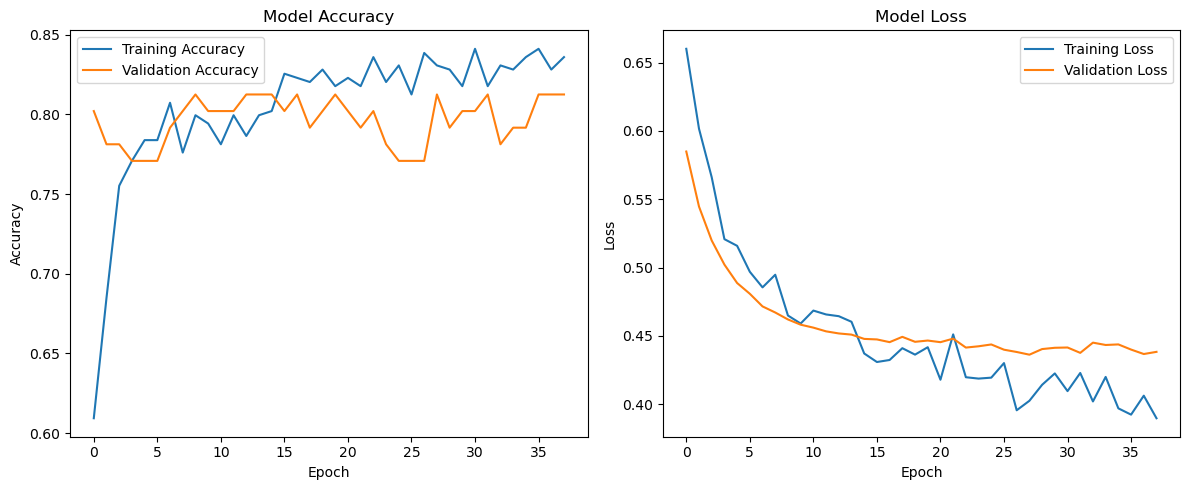

In [21]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [27]:
# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.8099
Precision: 0.7317
Recall: 0.7143
F1-score: 0.7229


In [23]:
# Calculate evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86        79
           1       0.73      0.71      0.72        42

    accuracy                           0.81       121
   macro avg       0.79      0.79      0.79       121
weighted avg       0.81      0.81      0.81       121



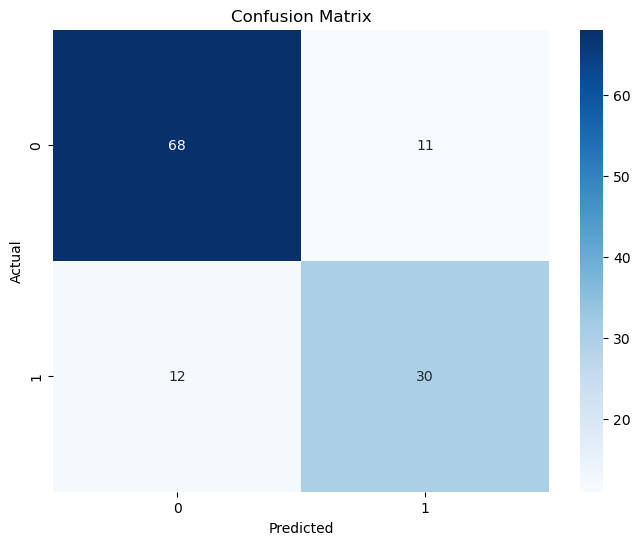

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

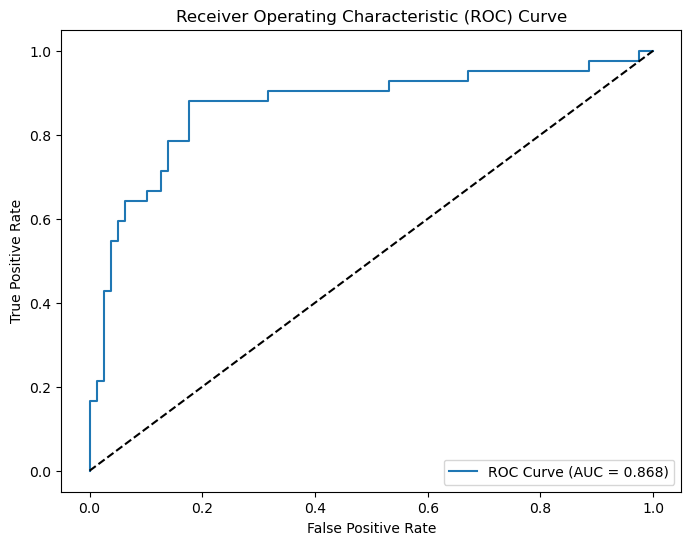

In [25]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Conclusion

In [29]:
print("Key findings:")
print(f"1. Model achieved good performance with accuracy score:{accuracy:.4f}")
print(f"2. AUC-ROC score: {roc_auc:.4f}")
print("3. The neural network successfully learned patterns in the Titanic dataset")
print("4. Early stopping helped prevent overfitting")
print("5. Preprocessing steps including missing value imputation and encoding improved model performance")

Key findings:
1. Model achieved good performance with accuracy score:0.8099
2. AUC-ROC score: 0.8683
3. The neural network successfully learned patterns in the Titanic dataset
4. Early stopping helped prevent overfitting
5. Preprocessing steps including missing value imputation and encoding improved model performance
